In [1]:
import os
import pandas as pd
import numpy as np
import vcf
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

### Plot quality scores

Some of the code used in this notebook was from [this tutotial](https://gatk.broadinstitute.org/hc/en-us/articles/360035889891--Notebook-Correlate-gCNV-callset-metrics-and-annotations).

>NP is the above tutorial are equal to 1kb whereas in our data they are target based or if targer > 250bp, then split into roughly equal chunks.

Available metrics & information:
- QUAL: PHRED Quality Score
- CN - Segment most-likely copy-number call
- GT - Segment genotype
- NP - Number of points (i.e. targets or bins) in the segment
- QA - Complementary Phred-scaled probability that all points (i.e. targets or bins) in the segment agree with the segment copy-number call
- QS - Complementary Phred-scaled probability that at least one point (i.e. target or bin) in the segment agrees with the segment copy-number call
- QSE - Complementary Phred-scaled probability that the segment end position is a genuine copy-number changepoint
- QSS - Complementary Phred-scaled probability that the segment start position is a genuine copy-number changepoint


In [2]:
# Create a dataframe for the known CNV status samples
val_samples=pd.read_csv('/home/adriana/Projects/CNV/220802_concordant_details.csv')

# Create dataframe with all raw calls from the three runs
all_data=pd.read_csv('/home/adriana/Projects/CNV/Validation/All_Validation_CNVs_unannotated-220929.csv')

# Get all the non-CNV validation samples
non_val_samples=all_data.loc[~all_data['Sample'].str.contains("NV")]

# Concatenated the CNV validation samples with the rest
# to enable 'Expected_Call' Status to filter through
data = pd.concat([val_samples,non_val_samples], ignore_index=True)
# Fill in NaN columns. This can be changed to Unknown or N/A if needed
data['Expected_Call']=data['Expected_Call'].fillna('NO')

Text(0.5, 0.98, 'Histograms of gCNV event sizes')

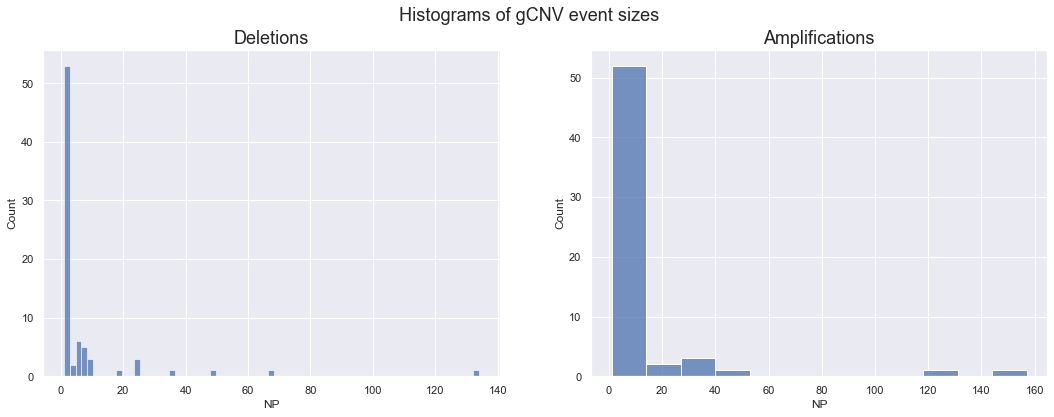

In [4]:
# Split deletions from amplifications based on reported copy-number
deletions = data.loc[data['CN'] < 2]
amplifications = data.loc[data['CN'] >2 ]




In [ ]:
# Create plot for number of targers (or intervals) called per CNV
fig, axs = plt.subplots(1,2, figsize=(18,6))
sns.histplot(deletions['NP'],ax=axs[0],kde=False)
sns.histplot(amplifications['NP'],ax=axs[1],kde=False,bins=12)

axs[0].set_title('Deletions', fontsize = 18)
axs[1].set_title('Amplifications', fontsize = 18)
plt.suptitle('Histograms of gCNV event sizes', fontsize = 18)

/tmp/ipykernel_375704/3077560011.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d=amplifications.append(deletions)


Text(0, 0.5, 'QS/NP')

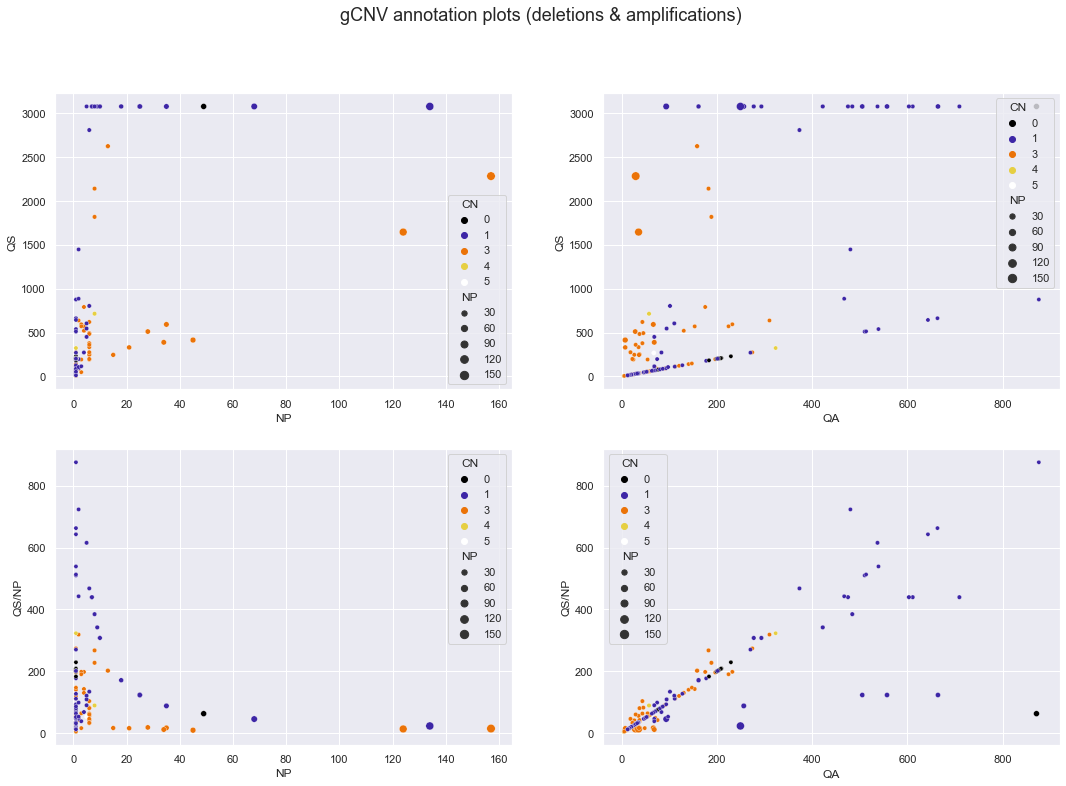

In [5]:
# df of both amplifications and deletions to plot collectively
d=amplifications.append(deletions)

# Create plots to visualise quality thresholds
# hue changes the colours and provides a legend based on copy-number in this instance
# size of points based on the number of points (intervals) called
fig, axs = plt.subplots(2,2, figsize=(18,12))
sns.scatterplot(x=d['NP'], y=d['QS'], hue=d['CN'], size=d['NP'], data=d, ax=axs[0,0], palette="CMRmap")
sns.scatterplot(x=d['QA'], y=d['QS'], hue=d['CN'], size=d['NP'], data=d, ax=axs[0,1], palette="CMRmap")

# QS/NP is meant to normalise the quality scores based on the points
# Please note that for CEN the bins/intervals in the NP are not equal to each other
# One bin is one target region in the capture unless more than 250bp
# if targer interval more than 250bp, split into roughly equal chunks
sns.scatterplot(x=d['NP'], y=d['QS']/d['NP'], hue=d['CN'], size=d['NP'], data=d, ax=axs[1,0], palette="CMRmap")
sns.scatterplot(x=d['QA'], y=d['QS']/d['NP'], hue=d['CN'], size=d['NP'], data=d, ax=axs[1,1], palette="CMRmap")

plt.suptitle('gCNV annotation plots (deletions & amplifications)', fontsize = 18)
axs[1,0].set_ylabel('QS/NP', fontsize=12)
axs[1,1].set_ylabel('QS/NP', fontsize=12)

In [6]:
# Calculate length of CNV
data['length'] = data['END'] - data['POS']

<AxesSubplot:xlabel='length', ylabel='Count'>

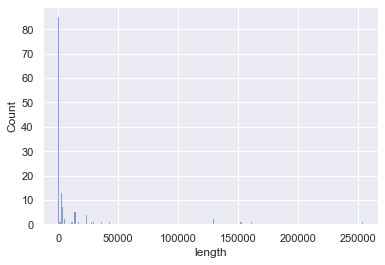

In [7]:
# One call is super long due to interval merging and made plotting bunch up at the start
# Filter dataset to remove and to add a note if this is used in validation write up
filtered_size = data.loc[data['length'] < 400000]
sns.histplot(filtered_size['length'],kde=False)


/tmp/ipykernel_375704/2910152935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_size['size_kb'] = filtered_size['length'] / 1000


<AxesSubplot:xlabel='size_kb', ylabel='Count'>

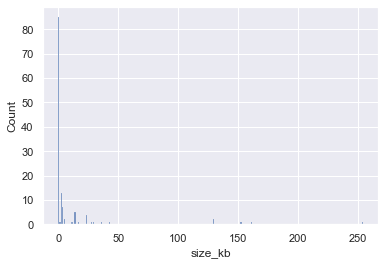

In [8]:
# Change x values to kb instead for ease of reading.
filtered_size['size_kb'] = filtered_size['length'] / 1000
sns.histplot(filtered_size['size_kb'],kde=False)


Text(0, 0.5, 'QS/NP')

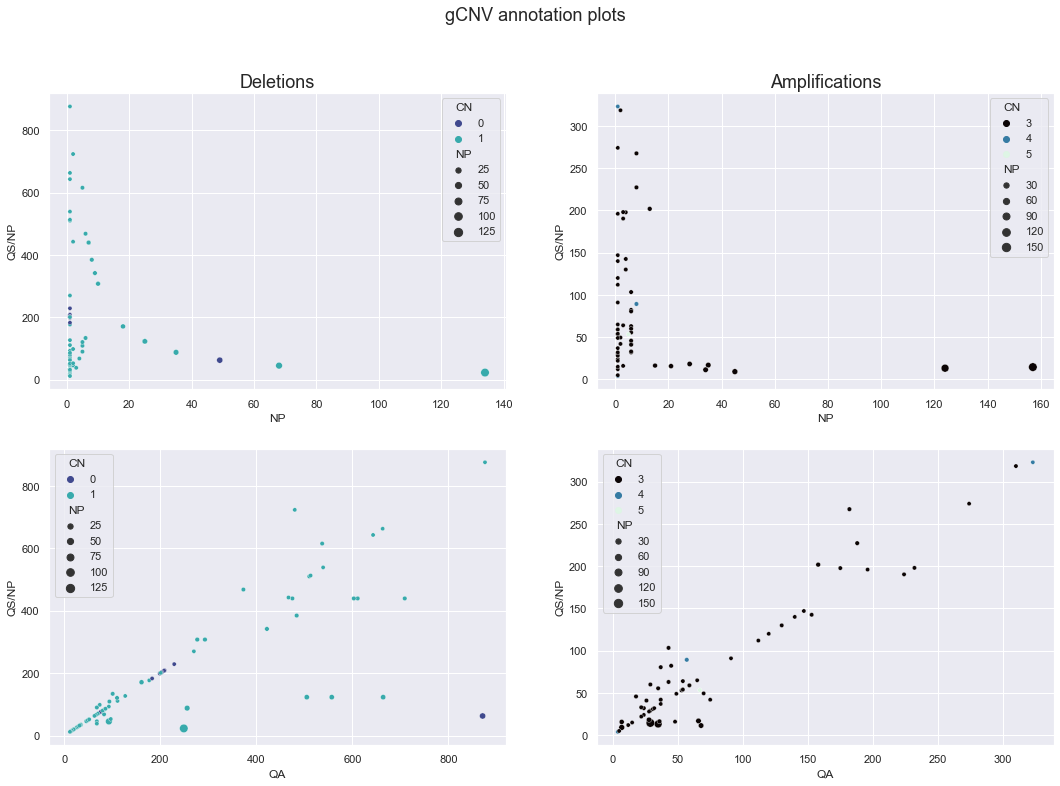

In [9]:
# Plot all events together and against QA
fig, axs = plt.subplots(2,2, figsize=(18,12))

sns.scatterplot(x=deletions['NP'], y=deletions['QS']/deletions['NP'], hue=deletions['CN'], size=deletions['NP'], data=deletions, ax=axs[0,0], palette="mako")
sns.scatterplot(x=amplifications['NP'], y=amplifications['QS']/amplifications['NP'], hue=amplifications['CN'], size=amplifications['NP'], data=amplifications, ax=axs[0,1], palette="mako")
sns.scatterplot(x=deletions['QA'], y=deletions['QS']/deletions['NP'], hue=deletions['CN'], size=deletions['NP'], data=deletions, ax=axs[1,0], palette="mako")
sns.scatterplot(x=amplifications['QA'], y=amplifications['QS']/amplifications['NP'], hue=amplifications['CN'], size=amplifications['NP'], data=amplifications, ax=axs[1,1], palette="mako")


plt.suptitle('gCNV annotation plots', fontsize = 18)
axs[0,0].set_title('Deletions', fontsize=18)
axs[0,1].set_title('Amplifications', fontsize=18)
axs[0,0].set_ylabel('QS/NP', fontsize=12)
axs[0,1].set_ylabel('QS/NP', fontsize=12)
axs[1,0].set_ylabel('QS/NP', fontsize=12)
axs[1,1].set_ylabel('QS/NP', fontsize=12)

Text(0, 0.5, 'QS/NP')

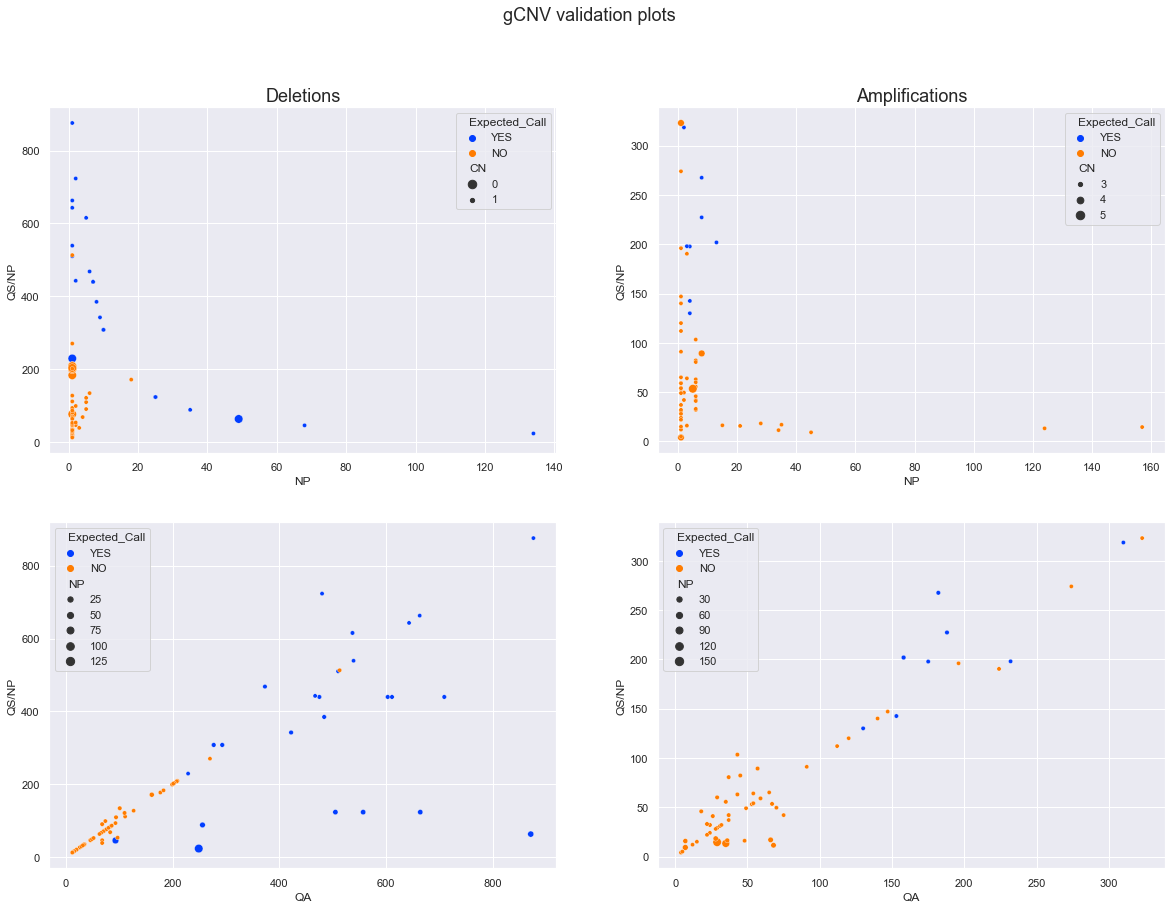

In [12]:
# Similar to above plots but instead of colour by copy-number
# Colour by whether it was an expected call or not.
fig, axs = plt.subplots(2,2, figsize=(20,14))

sns.scatterplot(x=deletions['NP'], y=deletions['QS']/deletions['NP'], hue=deletions['Expected_Call'], size=deletions['CN'], data=deletions, ax=axs[0,0], palette="bright",hue_order=['YES','NO'])
sns.scatterplot(x=amplifications['NP'], y=amplifications['QS']/amplifications['NP'], hue=amplifications['Expected_Call'], size=amplifications['CN'], data=amplifications, ax=axs[0,1], palette="bright",hue_order=['YES','NO'])
sns.scatterplot(x=deletions['QA'], y=deletions['QS']/deletions['NP'], hue=deletions['Expected_Call'], size=deletions['NP'], data=deletions, ax=axs[1,0], palette="bright",hue_order=['YES','NO'])
sns.scatterplot(x=amplifications['QA'], y=amplifications['QS']/amplifications['NP'], hue=amplifications['Expected_Call'], size=amplifications['NP'], data=amplifications, ax=axs[1,1], palette="bright",hue_order=['YES','NO'])


plt.suptitle('gCNV validation plots', fontsize = 18)
axs[0,0].set_title('Deletions', fontsize=18)
axs[0,1].set_title('Amplifications', fontsize=18)
axs[0,0].set_ylabel('QS/NP', fontsize=12)
axs[0,1].set_ylabel('QS/NP', fontsize=12)
axs[1,0].set_ylabel('QS/NP', fontsize=12)
axs[1,1].set_ylabel('QS/NP', fontsize=12)

Text(0, 0.5, 'QS/NP')

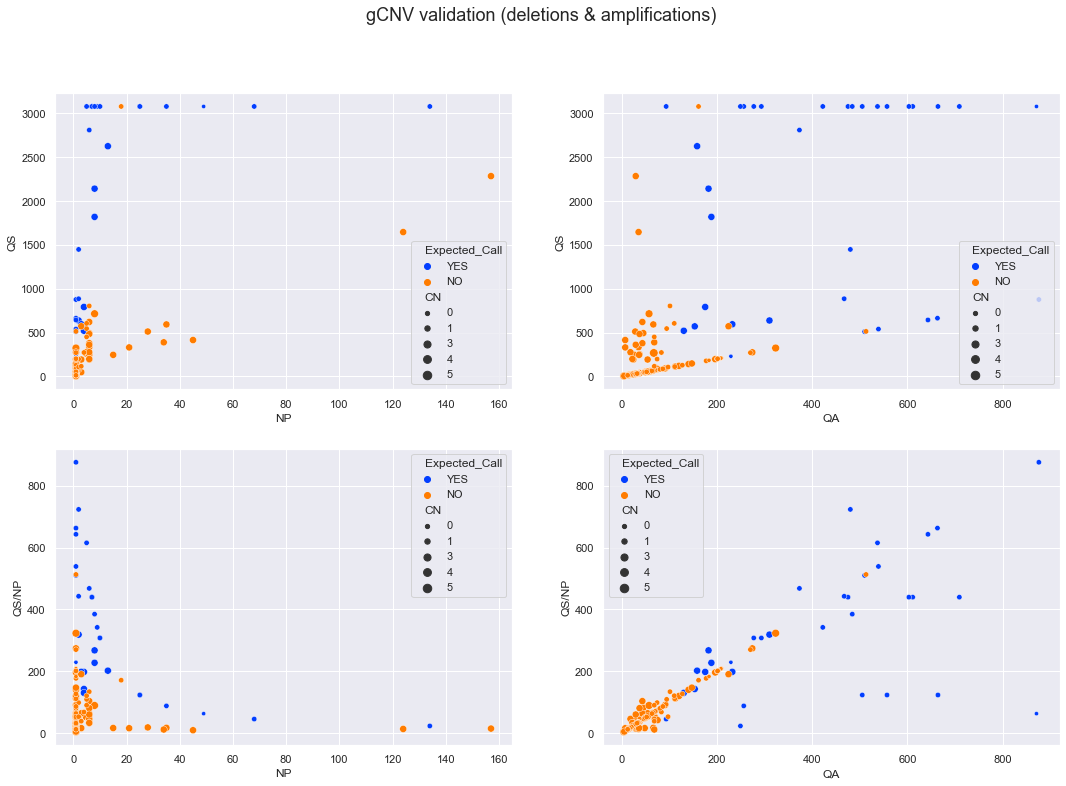

In [13]:
# Colour by whethere expected or not
fig, axs = plt.subplots(2,2, figsize=(18,12))
sns.scatterplot(x=d['NP'], y=d['QS'], hue=d['Expected_Call'], size=d['CN'], data=d, ax=axs[0,0], palette="bright")
sns.scatterplot(x=d['QA'], y=d['QS'], hue=d['Expected_Call'], size=d['CN'], data=d, ax=axs[0,1], palette="bright")
sns.scatterplot(x=d['NP'], y=d['QS']/d['NP'], hue=d['Expected_Call'], size=d['CN'], data=d, ax=axs[1,0], palette="bright")
sns.scatterplot(x=d['QA'], y=d['QS']/d['NP'], hue=d['Expected_Call'], size=d['CN'], data=d, ax=axs[1,1], palette="bright")

plt.suptitle('gCNV validation (deletions & amplifications)', fontsize = 18)
axs[1,0].set_ylabel('QS/NP', fontsize=12)
axs[1,1].set_ylabel('QS/NP', fontsize=12)


Text(0, 0.5, 'QS/NP')

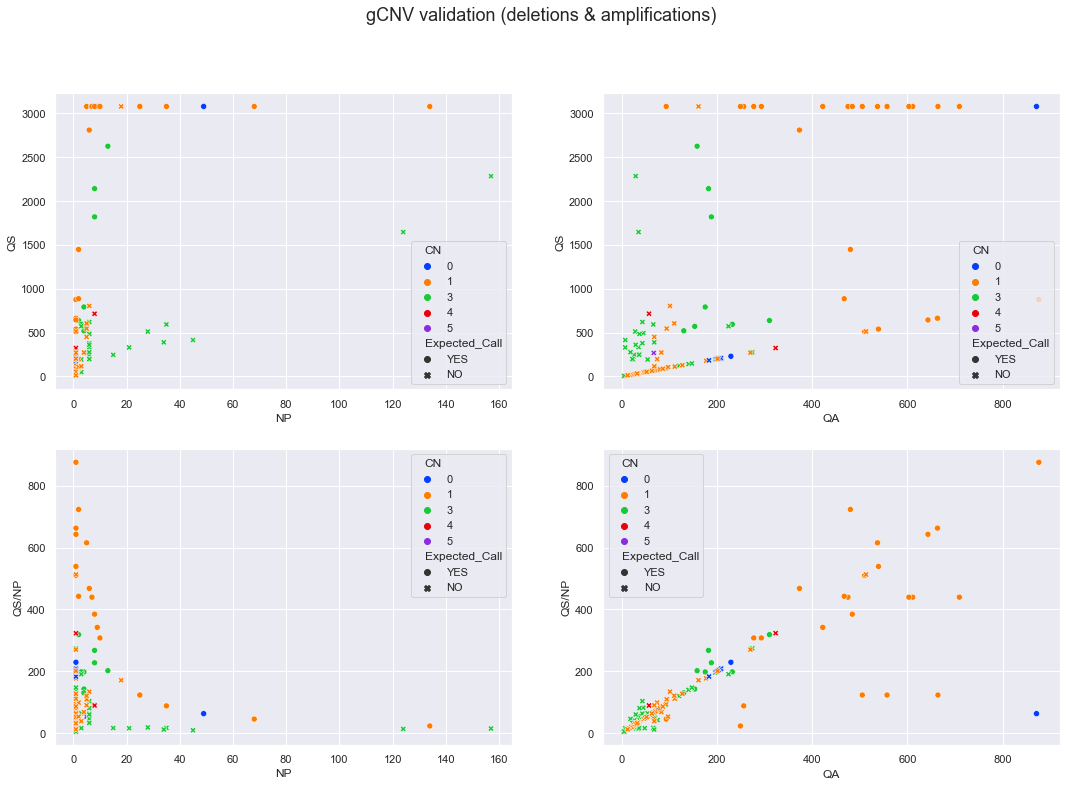

In [14]:
# Tried to incorporate symbols to see if more useful but I think it is not as user friendly
fig, axs = plt.subplots(2,2, figsize=(18,12))
sns.scatterplot(x=d['NP'], y=d['QS'], hue=d['CN'], style=d['Expected_Call'], data=d, ax=axs[0,0], palette="bright")
sns.scatterplot(x=d['QA'], y=d['QS'], hue=d['CN'], style=d['Expected_Call'], data=d, ax=axs[0,1], palette="bright")
sns.scatterplot(x=d['NP'], y=d['QS']/d['NP'], hue=d['CN'], style=d['Expected_Call'], data=d, ax=axs[1,0], palette="bright")
sns.scatterplot(x=d['QA'], y=d['QS']/d['NP'], hue=d['CN'], style=d['Expected_Call'], data=d, ax=axs[1,1], palette="bright")

plt.suptitle('gCNV validation (deletions & amplifications)', fontsize = 18)
axs[1,0].set_ylabel('QS/NP', fontsize=12)
axs[1,1].set_ylabel('QS/NP', fontsize=12)


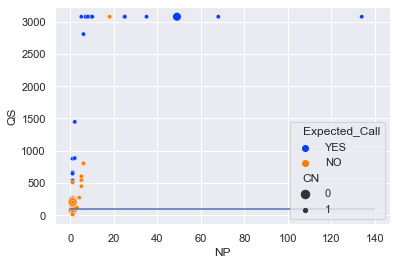

In [15]:

# Testing threshold lines for deletions, values can be changed.
sns.scatterplot(x=deletions['NP'], y=deletions['QS'], hue=deletions['Expected_Call'], size=deletions['CN'], data=deletions,  palette="bright")
plt.hlines(y=100,xmin=0,xmax=140)



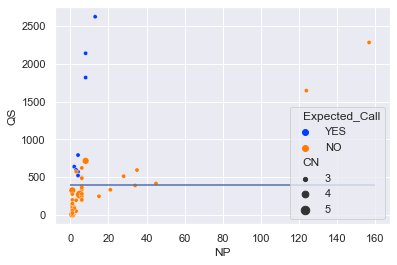

In [17]:
# Amplifiation threshold lines, threshold can be changed.
sns.scatterplot(x=amplifications['NP'], y=amplifications['QS'], hue=amplifications['Expected_Call'], size=amplifications['CN'], data=amplifications,  palette="bright")
plt.hlines(y=50,xmin=0,xmax=160)

Text(0.5, 0.98, 'gCNV validation (deletions & amplifications)')

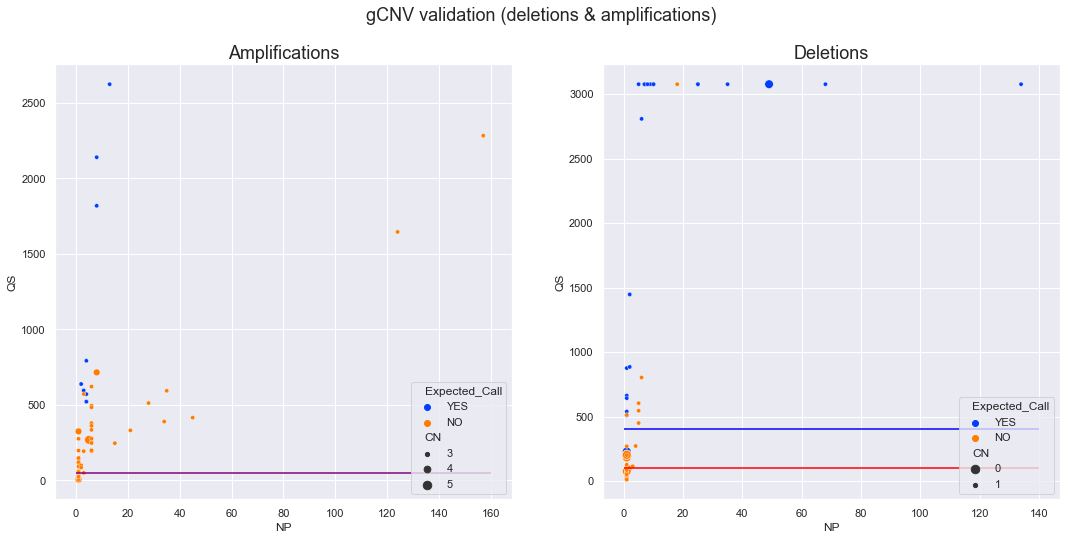

In [35]:
# Combination of above plots
fig, axs = plt.subplots(1,2, figsize=(18,8))
sns.scatterplot(x=amplifications['NP'], y=amplifications['QS'], hue=amplifications['Expected_Call'], size=amplifications['CN'], data=amplifications,  palette="bright",ax=axs[0])
axs[0].hlines(y=50,xmin=0,xmax=160,colors="purple")

sns.scatterplot(x=deletions['NP'], y=deletions['QS'], hue=deletions['Expected_Call'], size=deletions['CN'], data=deletions,  palette="bright",ax=axs[1])
axs[1].hlines(y=100,xmin=0,xmax=140,colors='red',label="Suggested Het threshold")
axs[1].hlines(y=400,xmin=0,xmax=140,colors='blue',label="Suggested Hom threshold")

axs[1].set_title('Deletions', fontsize=18)
axs[0].set_title('Amplifications', fontsize=18)

plt.suptitle('gCNV validation (deletions & amplifications)', fontsize = 18)


In [77]:
# Subset dataframe to colourcode scores for deletions only
del_qc=deletions[['Sample','ID','CN','NP','ALT','QA','QS','QSE','QSS']]

deletions

,Run,Sample,CHROM,POS,ID,REF,ALT,QUAL,END,GT,CN,NP,QA,QS,QSE,QSS,Expected_Call
0,39,CEN19CNV-GM1901529-CEN-F-EGG5_segments.vcf,X,32715957,CNV_X_32715957_32867976,N,<DEL>,3076.53,32867976,0/1,1,10,277,3077,318,462,YES
2,39,CEN23CNV-GM1817019-CEN-F-EGG5_segments.vcf,3,37038067,CNV_3_37038067_37038866,N,<DEL>,1446.51,37038866,0/1,1,2,480,1447,480,838,YES
3,39,CEN23CNV-GM1817019-CEN-F-EGG5_segments.vcf,5,42629113,CNV_5_42629113_42629232,N,<DEL>,229.28,42629232,1/1,0,1,229,229,229,229,YES
4,39,CEN25CNV-GM2001595-CEN-F-EGG5_segments.vcf,7,117144184,CNV_7_117144184_117149717,N,<DEL>,3076.53,117149717,0/1,1,5,537,3077,401,890,YES
5,39,CEN26CENV-GM1916027-CEN-F-EGG5_segments.vcf,13,32950659,CNV_13_32950659_32954345,N,<DEL>,3076.53,32954345,0/1,1,7,611,3077,645,719,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,50,X219092-GM2114021-CEN-F-EGG5_segments.vcf,9,140353454,CNV_9_140353454_140353604,N,<DEL>,52.38,140353604,0/1,1,1,52,52,52,52,NO
133,42,X218941-GM2112873-CEN-F-EGG5_segments.vcf,X,32328169,CNV_X_32328169_32328423,N,<DEL>,105.76,32328423,0/1,1,2,97,106,98,102,NO
134,42,X218941-GM2112873-CEN-F-EGG5_segments.vcf,X,32366439,CNV_X_32366439_32366920,N,<DEL>,115.27,32366920,0/1,1,3,68,115,68,52,NO
135,42,X218941-GM2112873-CEN-F-EGG5_segments.vcf,X,32398597,CNV_X_32398597_32398827,N,<DEL>,12.45,32398827,0/1,1,1,12,12,12,12,NO


In [93]:
#cm = sns.light_palette("blue", as_cmap=True) # this can create a colourscale from a colour

# Subset dataframe with information wanting to display
qc_vis=data[['Run','Sample','ID','length','CN','NP','ALT','QA','QS','QSE','QSS','Expected_Call']]

# Make everything strings to not colourt the CN,NP and length columns
qc_vis=qc_vis.astype(str)
# Revert to interger the values we want to visualise
qc_vis[['QA','QS','QSE','QSS']]=qc_vis[['QA','QS','QSE','QSS']].astype(int)
# Brackets make the whole value disappear so remove them
qc_vis['ALT'] = qc_vis['ALT'].str.replace("<|>","",regex=True)

# Sort values first by QS (probability of at least on interval being correct)
# Then by QA (probability of all intervals being correct)
qc_vis=qc_vis.sort_values(by=["QS","QA"],ascending=False)

# Colour code values accordingly
qc_vis.style.background_gradient(axis=0,cmap = 'YlGnBu')



,Run,Sample,ID,length,CN,NP,ALT,QA,QS,QSE,QSS,Expected_Call
22,42,CEN36CNV-GM1907941-CEN-M-EGG5_segments.vcf,CNV_X_32360187_32614023,253836,0,49,DEL,871,3077,2210,3077,YES
7,42,CEN26CNVR-GM2001595-CEN-F-EGG5_segments.vcf,CNV_13_32950659_32954345,3686,1,7,DEL,709,3077,709,831,YES
12,39,CEN33CNV-GM1814397-CEN-M-EGG5_segments.vcf,CNV_2_48010173_48034199,24026,1,25,DEL,664,3077,404,740,YES
5,39,CEN26CENV-GM1916027-CEN-F-EGG5_segments.vcf,CNV_13_32950659_32954345,3686,1,7,DEL,611,3077,645,719,YES
6,39,CEN26CNV2-GM1916027-CEN-F-EGG5_segments.vcf,CNV_13_32950659_32954345,3686,1,7,DEL,603,3077,668,709,YES
13,39,CEN33CNV2-GM1814397-CEN-M-EGG5_segments.vcf,CNV_2_48010173_48034199,24026,1,25,DEL,557,3077,653,711,YES
4,39,CEN25CNV-GM2001595-CEN-F-EGG5_segments.vcf,CNV_7_117144184_117149717,5533,1,5,DEL,537,3077,401,890,YES
14,42,CEN33CNVR-GM1814397-CEN-M-EGG5_segments.vcf,CNV_2_48010173_48034199,24026,1,25,DEL,505,3077,571,505,YES
32,42,CEN42CNV-GM1805724-CEN-M-EGG5_segments.vcf,CNV_7_117144184_117171286,27102,1,8,DEL,484,3077,587,722,YES
30,42,CEN40CNV-GM2012154-CEN-M-EGG5_segments.vcf,CNV_13_32950659_32954345,3686,1,7,DEL,475,3077,475,566,YES


In [86]:
qc_vis[]

,Run,Sample,ID,length,CN,NP,ALT,QA,QS,QSE,QSS,Expected_Call
22,42,CEN36CNV-GM1907941-CEN-M-EGG5_segments.vcf,CNV_X_32360187_32614023,253836,0,49,<DEL>,871,3077,2210,3077,YES
7,42,CEN26CNVR-GM2001595-CEN-F-EGG5_segments.vcf,CNV_13_32950659_32954345,3686,1,7,<DEL>,709,3077,709,831,YES
12,39,CEN33CNV-GM1814397-CEN-M-EGG5_segments.vcf,CNV_2_48010173_48034199,24026,1,25,<DEL>,664,3077,404,740,YES
5,39,CEN26CENV-GM1916027-CEN-F-EGG5_segments.vcf,CNV_13_32950659_32954345,3686,1,7,<DEL>,611,3077,645,719,YES
6,39,CEN26CNV2-GM1916027-CEN-F-EGG5_segments.vcf,CNV_13_32950659_32954345,3686,1,7,<DEL>,603,3077,668,709,YES
...,...,...,...,...,...,...,...,...,...,...,...,...
98,42,CEN51R-GM1904234-CEN-F-EGG5_segments.vcf,CNV_4_126752933_126753052,119,1,1,<DEL>,13,13,13,13,NO
77,42,X219744-GM2120088-CEN-M-EGG5_segments.vcf,CNV_2_10138981_10139100,119,3,1,<DUP>,12,12,12,12,NO
135,42,X218941-GM2112873-CEN-F-EGG5_segments.vcf,CNV_X_32398597_32398827,230,1,1,<DEL>,12,12,12,12,NO
126,50,X220149-GM2200363-CEN-F-EGG5_segments.vcf,CNV_6_32008153_32008392,239,3,1,<DUP>,5,5,5,5,NO
